In [1]:
import pennylane as qml
import jax
import optax
from pennylane import numpy as np
from jax import numpy as jnp
import matplotlib.pyplot as plt

In [15]:
def generate_data_matrix(num_points, std, seed):
    np.random.seed(seed)
    
    # Generate points in the range [-2π, 2π]
    X = np.linspace(-2 * np.pi, 2 * np.pi, num_points * 4)
    
    # Compute the sine values for these points
    Y = np.sin(X)
    
    # Add random noise to the sine values
    noise = np.random.normal(0, std, Y.shape)
    Y_noisy = Y + noise
    
    # Split the sine values into matrices of four values
    X_matrices = X.reshape(num_points, 4)
    Y_matrices = Y_noisy.reshape(num_points, 4)
    
    return X_matrices, Y_matrices

In [27]:
X_train_data, Y_train_data = generate_data_matrix(num_points=100, std=0.1, seed=17)
X_train_data.requires_grad = False
Y_train_data.requires_grad = False

X_test_data, Y_test_data = generate_data_matrix(num_points=50, std=0.1, seed=106)

In [28]:
X_train_data.shape

(100, 4)

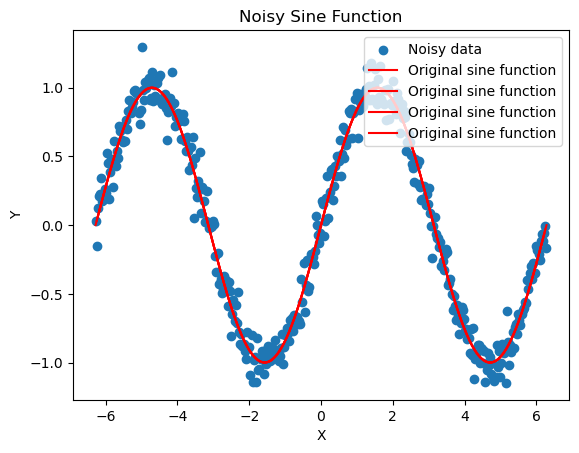

In [29]:
plt.scatter(X_train_data, Y_train_data, label='Noisy data')
plt.plot(X_train_data, np.sin(X_train_data), label='Original sine function', color='red')
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Noisy Sine Function')
plt.show()

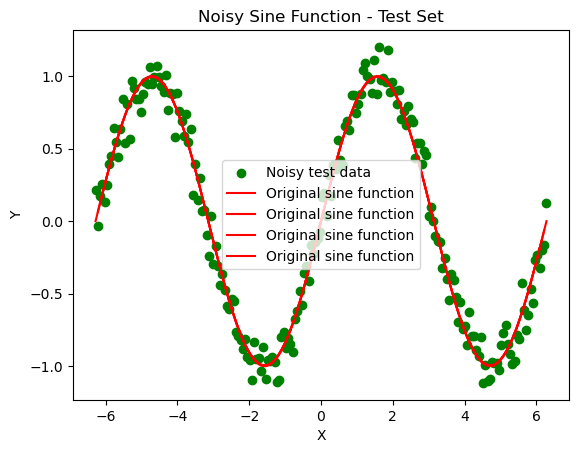

In [18]:
plt.scatter(X_test_data, Y_test_data, label='Noisy test data', color='green')
plt.plot(X_test_data, np.sin(X_test_data), label='Original sine function', color='red')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Noisy Sine Function - Test Set')
plt.show()

In [31]:
dev = qml.device('default.qubit', wires=4)

In [32]:
@qml.qnode(dev)
def circuit(weights, data):
    qml.AngleEmbedding(data, wires=range(4), rotation='X')

    qml.StronglyEntanglingLayers(weights=weights, wires=range(4))

    return qml.expval(qml.PauliZ(wires=0))

(<Figure size 500x500 with 1 Axes>, <Axes: >)

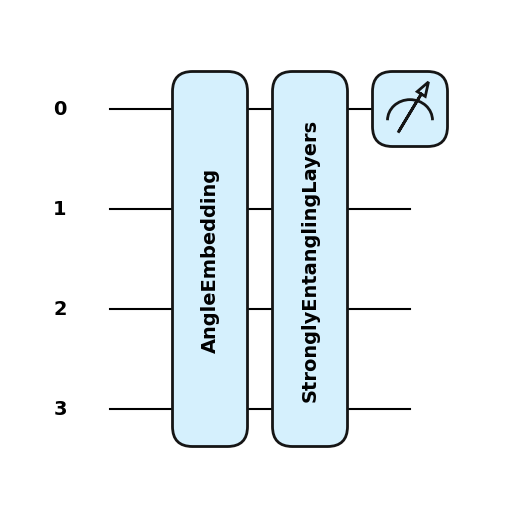

In [33]:
qml.draw_mpl(circuit, style='pennylane')([[[0,0,0], [0,0,0], [0,0,0], [0,0,0]]], [0,0,0,0])

In [34]:
def sine_model(data, weights, bias):
    return circuit(weights, data) + bias

In [38]:
@jax.jit
def loss_func(params, data, targets):
    preds = sine_model(data, params['weights'], params['bias'])
    total_loss = 0
    for y in targets:
        loss = jnp.sum((y[0] - preds) ** 2 / len(data))
        total_loss += loss
    return loss

In [ ]:
def accuracy(labels, predictions):
    acc = sum(abs(labs - preds) < 1e-5 for labs, preds in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [50]:
layers = 3

w = jnp.ones([layers, 4, 3])
b = jnp.array(0.15)
parametres = {'weights': w, 'bias': b}

In [39]:
print(loss_func(parametres, X_train_data, Y_train_data))

print(jax.grad(loss_func)(parametres, X_train_data, Y_train_data))

0.17073917
{'bias': Array(0.62385434, dtype=float32, weak_type=True), 'weights': Array([[[-2.29131263e-02, -2.21326277e-02, -5.11581227e-02],
        [-1.03459865e-01, -8.77724886e-02,  1.84268132e-03],
        [ 2.00183243e-02,  3.61642241e-02, -9.11599994e-02],
        [ 6.46082405e-03,  2.90160999e-02,  2.57267319e-02]],

       [[ 7.68163055e-02,  3.85534912e-02,  4.86607216e-02],
        [ 7.52645880e-02,  1.52872950e-02,  1.02221295e-01],
        [-6.30296171e-02,  9.21672732e-02,  1.00451156e-01],
        [ 4.13736366e-02,  1.83703527e-02,  7.78559595e-02]],

       [[ 1.00451224e-01, -5.42911924e-02,  3.91155481e-08],
        [ 7.78560042e-02, -4.91280966e-02, -1.67638063e-08],
        [ 3.35276127e-08, -1.49011612e-08,  1.86264515e-08],
        [ 0.00000000e+00,  0.00000000e+00,  1.49011612e-08]]],      dtype=float32)}


In [46]:
opt = optax.adam(learning_rate=0.25)

@jax.jit
def update(iteration, arguments):
    params, state, data, targets = arguments

    loss_val, gradients = jax.value_and_grad(loss_func)(params, data, targets)
    updates, state = opt.update(gradients, state)
    params = optax.apply_updates(params, updates)

    def print_steps():
        jax.debug.print("Step: {i}  Loss: {loss_val}", i=iteration, loss_val=loss_val)

    jax.lax.cond((jnp.mod(iteration, 5) == 0), print_steps, lambda: None)

    return (params, state, data, targets)

@jax.jit
def optimise(params, data, targets):

    opt_state = opt.init(params)
    arguments = (params, opt_state, data, targets)
    (params, opt_state, _, _) = jax.lax.fori_loop(0, 60, update, arguments)

    return params

In [51]:
optimise(parametres, X_train_data, Y_train_data)

Step: 0  Loss: 0.17073917388916016
Step: 5  Loss: 0.010859272442758083
Step: 10  Loss: 0.0031940541230142117
Step: 15  Loss: 0.0060666706413030624
Step: 20  Loss: 0.0021620988845825195
Step: 25  Loss: 0.001755222212523222
Step: 30  Loss: 0.0008431496098637581
Step: 35  Loss: 0.0006972913397476077
Step: 40  Loss: 0.00022086271201260388
Step: 45  Loss: 0.0002527767501305789
Step: 50  Loss: 0.00010795607522595674
Step: 55  Loss: 9.67337837209925e-05


{'bias': Array(-0.16347839, dtype=float32),
 'weights': Array([[[ 2.8679903 ,  3.2843175 ,  2.297839  ],
         [ 2.2327638 ,  0.73869926,  0.4401425 ],
         [-0.13590994, -0.28753468,  1.7190804 ],
         [ 2.1301768 ,  0.8905398 ,  1.3803933 ]],
 
        [[-0.28340927, -0.79763997,  0.23910262],
         [ 1.0216933 , -1.990651  ,  1.1595589 ],
         [ 1.9749362 , -0.0943878 ,  0.05317843],
         [ 1.2455801 , -0.5850573 ,  0.80151933]],
 
        [[ 0.0531781 ,  0.24872747, -0.34318832],
         [ 0.8015193 ,  1.5753566 ,  0.21175872],
         [-0.12355964,  2.1448836 , -0.14548238],
         [ 0.7301907 ,  0.9101893 , -0.27147368]]], dtype=float32)}

In [52]:
parametres = optimise(parametres, X_train_data, Y_train_data);

Step: 0  Loss: 0.17073917388916016
Step: 5  Loss: 0.010859272442758083
Step: 10  Loss: 0.0031940541230142117
Step: 15  Loss: 0.0060666706413030624
Step: 20  Loss: 0.0021620988845825195
Step: 25  Loss: 0.001755222212523222
Step: 30  Loss: 0.0008431496098637581
Step: 35  Loss: 0.0006972913397476077
Step: 40  Loss: 0.00022086271201260388
Step: 45  Loss: 0.0002527767501305789
Step: 50  Loss: 0.00010795607522595674
Step: 55  Loss: 9.67337837209925e-05


c:\Users\User\anaconda3\envs\nickel\lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'jax', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


ValueError: x and y must be the same size

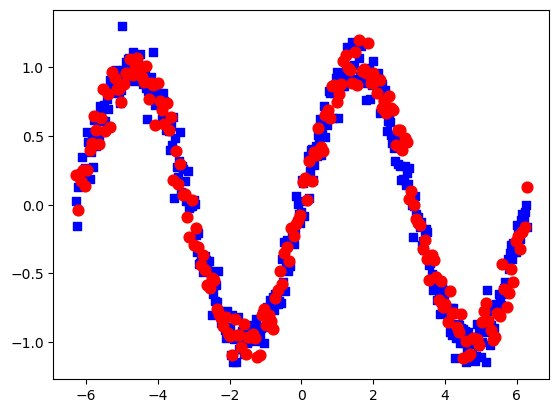

In [70]:
test_preds = []
for x_test in X_test_data:
    pred = sine_model(X_test_data, parametres['weights'], parametres['bias'])
    test_preds.append(pred)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_train_data, Y_train_data, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test_data, Y_test_data, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test_data, test_preds[0], s=30, c='k', marker="x", label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right')
plt.show()

In [68]:
test_preds = []
for x_test in X_test_data:
    pred = sine_model(X_test_data, parametres['weights'], parametres['bias'])
    test_preds.append(pred)

In [71]:
test_preds[0]

Array([-0.11920099, -0.11686035, -0.11481686, -0.11285515, -0.1108989 ,
       -0.11010455, -0.11212988, -0.11718203, -0.12296261, -0.12596841,
       -0.12432112, -0.11959572, -0.11573417, -0.11571147, -0.11878513,
       -0.12087692, -0.11797459, -0.10974859, -0.10027115, -0.09513898,
       -0.09734313, -0.10523532, -0.11407216, -0.11960365, -0.1206619 ,
       -0.11891343, -0.11658461, -0.11457725, -0.11259945, -0.11069967,
       -0.11017711, -0.11261906, -0.11793543, -0.12355627, -0.1260197 ,
       -0.12382959, -0.11898018, -0.1154951 , -0.11598738, -0.11920084,
       -0.12084009, -0.11719073, -0.10851465, -0.09929074, -0.09500192,
       -0.0980994 , -0.10639526, -0.11500297, -0.11996643, -0.12054582],      dtype=float32)